# Combined network: 

- Encoder-decoder unit --> Local network with self-supervised learning --> mimic PV?

- Encoder-classifier unit --> Global network with supervised learning --> mimic SST?


In [90]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import csv
from datetime import datetime
from sklearn.metrics import silhouette_score
import statistics

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Dataset

In [91]:
from dataset import get_mnist_dataset
working_directory = os.getcwd()
data_dir = os.path.join(working_directory, './dataset')
batch_size_train = 64
batch_size_test = 1000

train_data_loader, test_data_loader = get_mnist_dataset(data_dir, batch_size_train=batch_size_train, batch_size_test=batch_size_test)

print('Train dataset size: {}'.format(len(train_data_loader.dataset)))
print('Test dataset size: {}'.format(len(test_data_loader.dataset)))

Train dataset size: 60000
Test dataset size: 10000


### Model

In [92]:
from modules.network import PV_SST_Pyr

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PV_SST_Pyr(thal_input_dim = 784, latent_dim=32, output_dim=10).to(device)

print(model)

PV_SST_Pyr(
  (encoder): encoder(
    (flatten): Flatten()
    (activation): Sigmoid()
    (fc1): Linear(in_features=784, out_features=32, bias=True)
  )
  (decoder): decoder(
    (activation): Sigmoid()
    (fc1): Linear(in_features=32, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=784, bias=True)
  )
  (classifier): classifier(
    (fc1): Linear(in_features=32, out_features=10, bias=True)
    (activation): Sigmoid()
  )
)


In [93]:
for name, param in model.named_parameters():
    print (name)   

encoder.fc1.weight
encoder.fc1.bias
decoder.fc1.weight
decoder.fc1.bias
decoder.fc2.weight
decoder.fc2.bias
classifier.fc1.weight
classifier.fc1.bias


### Train & test

In [94]:
from modules.utils import print_grad_norms, compute_losses
from modules.metrics import calculate_ssim, calculate_accuracy
from modules.metrics import visualize_tsne, plot_digits
from modules.metrics import  tsne_and_clustering, plot_digits_and_saliency
from modules.utils import weight_update, successive_learning
from modules.metrics import calculate_nmi
from modules.metrics import calculate_multiple_accuracy


momentum = 0.5
loss_fn = nn.MSELoss()


num_epochs = 250
log_interval = 400
alpha = 1 
lr = 2
Condition = "Normal"
Digits = np.nan
swap_epoch = 140

train_losses, train_recon_losses, train_global_losses  = [], [], []
train_ssim, train_acc = [], []
train_counter = []
test_losses, test_ssim, test_acc, test_silhouette = [], [], [], []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]
nmi_score = []
silhouette = []

AlphaForEpochSup140 = 0.5


In [95]:
def train(epoch, dataloader, model, loss_fn, alpha):
    recon_loss_avg, global_loss_avg, loss_avg, total, correct = 0,0,0,0,0
    model.train() 
    for batch_idx, batch in enumerate(dataloader):
        thal_input, target = batch 
        t = F.one_hot(target, num_classes=10).float()
        _, recon, output = model(thal_input)

        alpha, lr = successive_learning(epoch, model)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        if epoch is not None and (epoch > swap_epoch):
                alpha= AlphaForEpochSup140

        recon_loss, global_loss, total_loss = compute_losses(recon, thal_input, output, t, loss_fn, alpha)
        #ssim_score = calculate_ssim(recon, thal_input)
        _, _, accuracy = calculate_accuracy(target, output, total, correct)
        recon_loss_avg += recon_loss.item()
        global_loss_avg += global_loss.item()
        loss_avg += total_loss.item()

        weight_update(model, optimizer, recon_loss, global_loss, total_loss)
        optimizer.step()
        optimizer.zero_grad()
        
        if batch_idx % log_interval == 0:
            train_losses.append(total_loss.item())
            train_recon_losses.append(recon_loss.item())
            train_global_losses.append(global_loss.item())
            train_ssim.append(calculate_ssim(recon, thal_input))
            train_acc.append(accuracy)
            train_counter.append((batch_idx*64) + ((epoch-1)*len(dataloader.dataset)))
            #print_grad_norms(model.encoder, "Encoder")
            #print_grad_norms(model.decoder, "Decoder")
            #print_grad_norms(model.classifier, "Classifier")

    recon_loss_avg, global_loss_avg, loss_avg = (loss / len(dataloader) for loss in (
        recon_loss_avg, global_loss_avg, loss_avg))
    print('Epoch: {} Recon_loss: {:.6f} Global_loss: {:.6f}  Total loss: {:.6f}'.format(
        epoch, recon_loss_avg, global_loss_avg, loss_avg))

In [96]:
def test(dataloader, model, loss_fn, alpha, epoch=None):
    model.eval()
    recon_loss_avg, global_loss_avg, test_loss_avg, ssim_avg = 0,0,0,0
    encoded_outputs = []
    labels = []
    total, correct, accuracy = {i: 0 for i in range(10)}, {i: 0 for i in range(10)}, {}
    with torch.no_grad():
        for batch in dataloader:
            thal_input, target = batch
            t = F.one_hot(target, num_classes=10).float()
            encoded, recon, output = model(thal_input)

            alpha, _ = successive_learning(epoch, model)

            if epoch is not None and (epoch > swap_epoch):
                alpha= AlphaForEpochSup140
            recon_loss, global_loss, total_loss = compute_losses(recon, thal_input, output, t, loss_fn, alpha)

            ssim_avg += calculate_ssim(recon, thal_input)
            calculate_multiple_accuracy(target, output, total, correct)
            recon_loss_avg += recon_loss.item()
            global_loss_avg += global_loss.item()
            test_loss_avg += total_loss.item()
            encoded_outputs.append(encoded)
            labels.append(target)
                  
    recon_loss_avg, global_loss_avg, test_loss_avg, ssim_avg = (loss / len(dataloader) for loss in (
        recon_loss_avg, global_loss_avg, test_loss_avg, ssim_avg))
    test_ssim.append(ssim_avg)
    test_losses.append(test_loss_avg)
    encoded_outputs = torch.cat(encoded_outputs)
    labels = torch.cat(labels)
    nmi = calculate_nmi(encoded_outputs, labels)
    nmi_score.append(nmi)
    silh = silhouette_score(encoded_outputs, labels)
    silhouette.append(silh)
    if epoch is None or (epoch is not None and epoch % 10 == 0):
        pass
            #visualize_tsne(encoded_outputs, labels, epoch)
            #plot_digits(model, dataloader, n=5,swap_argument=None, epoch=epoch)
            #silhouette_score = tsne_and_clustering(encoded_outputs, labels, epoch)
            #test_silhouette.append(silhouette_score)
            #plot_digits_and_saliency(model, dataloader, n=5,swap_argument=None, epoch=epoch)
            #print('Silhouette score: {}'.format(silhouette_score))
    for digit in range(10):
        accuracy[digit] = (correct[digit] / total[digit] * 100) if total[digit] > 0 else float('nan')
    test_acc.append(accuracy)
    print('Test set: Recon_loss: {:.6f} Global_loss: {:.6f} Acc: {}   SSIM {:.6f} Silhouette {} NMI {}\n'.format(
        recon_loss_avg, global_loss_avg, accuracy, ssim_avg, silh, nmi))

In [87]:
test(test_data_loader, model, loss_fn, alpha)

for epoch in range(1, num_epochs + 1):
  train(epoch, train_data_loader, model, loss_fn, alpha)
  test(test_data_loader, model, loss_fn, alpha, epoch)

Test set: Recon_loss: 1.264724 Global_loss: 0.283899 Acc: {0: 0.0, 1: 0.0, 2: 6.782945736434108, 3: 95.84158415841584, 4: 1.5274949083503055, 5: 0.0, 6: 0.0, 7: 0.0, 8: 3.798767967145791, 9: 0.0}   SSIM -0.037159 Silhouette 0.02963882125914097 NMI 0.37407966460494485

Epoch: 1 Recon_loss: 0.824005 Global_loss: 0.303687  Total loss: 0.824005
Test set: Recon_loss: 0.808074 Global_loss: 0.304576 Acc: {0: 0.20408163265306123, 1: 0.0, 2: 0.5813953488372093, 3: 100.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}   SSIM 0.029542 Silhouette -0.10377336293458939 NMI 0.15608796558800542

Epoch: 2 Recon_loss: 0.803202 Global_loss: 0.301661  Total loss: 0.803202
Test set: Recon_loss: 0.805751 Global_loss: 0.296847 Acc: {0: 0.0, 1: 0.0, 2: 5.426356589147287, 3: 99.70297029702971, 4: 3.462321792260693, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}   SSIM 0.030781 Silhouette -0.18847766518592834 NMI 0.18491009251241414

Epoch: 3 Recon_loss: 0.800608 Global_loss: 0.291841  Total loss: 0.800608
Test set: 

In [97]:
for i in range(10):
    model = PV_SST_Pyr(thal_input_dim = 784, latent_dim=32, output_dim=10).to(device)
    momentum = 0.5
    loss_fn = nn.MSELoss()


    num_epochs = 250
    log_interval = 400
    alpha = 1 
    lr = 2
    Condition = "Normal"
    Digits = np.nan
    swap_epoch = 140

    train_losses, train_recon_losses, train_global_losses  = [], [], []
    train_ssim, train_acc = [], []
    train_counter = []
    test_losses, test_ssim, test_acc, test_silhouette = [], [], [], []
    test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]
    nmi_score = []
    silhouette = []

    AlphaForEpochSup140 = 0.2

    test(test_data_loader, model, loss_fn, alpha)

    for epoch in range(1, num_epochs + 1):
        train(epoch, train_data_loader, model, loss_fn, alpha)
        test(test_data_loader, model, loss_fn, alpha, epoch)

    with open('data_2.csv', mode='a', newline='') as data_file:
        writer = csv.writer(data_file)
        writer.writerow([
            datetime.now(),
            num_epochs,
            swap_epoch,
            AlphaForEpochSup140,
            Condition,
            Digits,
            silhouette,
            nmi_score,
            [acc_epoch[0] for acc_epoch in test_acc],
            [acc_epoch[1] for acc_epoch in test_acc],
            [acc_epoch[2] for acc_epoch in test_acc],
            [acc_epoch[3] for acc_epoch in test_acc],
            [acc_epoch[4] for acc_epoch in test_acc],
            [acc_epoch[5] for acc_epoch in test_acc],
            [acc_epoch[6] for acc_epoch in test_acc],
            [acc_epoch[7] for acc_epoch in test_acc],
            [acc_epoch[8] for acc_epoch in test_acc],
            [acc_epoch[9] for acc_epoch in test_acc],
            [statistics.mean(epoch.values()) for epoch in test_acc],  
            test_ssim,
            np.nan,
            np.nan
        ])
    
for i in range(10):
    model = PV_SST_Pyr(thal_input_dim = 784, latent_dim=32, output_dim=10).to(device)
    momentum = 0.5
    loss_fn = nn.MSELoss()


    num_epochs = 250
    log_interval = 400
    alpha = 1 
    lr = 2
    Condition = "Normal"
    Digits = np.nan
    swap_epoch = 140

    train_losses, train_recon_losses, train_global_losses  = [], [], []
    train_ssim, train_acc = [], []
    train_counter = []
    test_losses, test_ssim, test_acc, test_silhouette = [], [], [], []
    test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]
    nmi_score = []
    silhouette = []

    AlphaForEpochSup140 = 0.8

    test(test_data_loader, model, loss_fn, alpha)

    for epoch in range(1, num_epochs + 1):
        train(epoch, train_data_loader, model, loss_fn, alpha)
        test(test_data_loader, model, loss_fn, alpha, epoch)

    with open('data_2.csv', mode='a', newline='') as data_file:
        writer = csv.writer(data_file)
        writer.writerow([
            datetime.now(),
            num_epochs,
            swap_epoch,
            AlphaForEpochSup140,
            Condition,
            Digits,
            silhouette,
            nmi_score,
            [acc_epoch[0] for acc_epoch in test_acc],
            [acc_epoch[1] for acc_epoch in test_acc],
            [acc_epoch[2] for acc_epoch in test_acc],
            [acc_epoch[3] for acc_epoch in test_acc],
            [acc_epoch[4] for acc_epoch in test_acc],
            [acc_epoch[5] for acc_epoch in test_acc],
            [acc_epoch[6] for acc_epoch in test_acc],
            [acc_epoch[7] for acc_epoch in test_acc],
            [acc_epoch[8] for acc_epoch in test_acc],
            [acc_epoch[9] for acc_epoch in test_acc],
            [statistics.mean(epoch.values()) for epoch in test_acc],  
            test_ssim,
            np.nan,
            np.nan
        ])
    
for i in range(10):
    model = PV_SST_Pyr(thal_input_dim = 784, latent_dim=32, output_dim=10).to(device)
    momentum = 0.5
    loss_fn = nn.MSELoss()


    num_epochs = 250
    log_interval = 400
    alpha = 1 
    lr = 2
    Condition = "Normal"
    Digits = np.nan
    swap_epoch = 140

    train_losses, train_recon_losses, train_global_losses  = [], [], []
    train_ssim, train_acc = [], []
    train_counter = []
    test_losses, test_ssim, test_acc, test_silhouette = [], [], [], []
    test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]
    nmi_score = []
    silhouette = []

    AlphaForEpochSup140 = 0.5

    test(test_data_loader, model, loss_fn, alpha)

    for epoch in range(1, num_epochs + 1):
        train(epoch, train_data_loader, model, loss_fn, alpha)
        test(test_data_loader, model, loss_fn, alpha, epoch)

    with open('data_2.csv', mode='a', newline='') as data_file:
        writer = csv.writer(data_file)
        writer.writerow([
            datetime.now(),
            num_epochs,
            swap_epoch,
            AlphaForEpochSup140,
            Condition,
            Digits,
            silhouette,
            nmi_score,
            [acc_epoch[0] for acc_epoch in test_acc],
            [acc_epoch[1] for acc_epoch in test_acc],
            [acc_epoch[2] for acc_epoch in test_acc],
            [acc_epoch[3] for acc_epoch in test_acc],
            [acc_epoch[4] for acc_epoch in test_acc],
            [acc_epoch[5] for acc_epoch in test_acc],
            [acc_epoch[6] for acc_epoch in test_acc],
            [acc_epoch[7] for acc_epoch in test_acc],
            [acc_epoch[8] for acc_epoch in test_acc],
            [acc_epoch[9] for acc_epoch in test_acc],
            [statistics.mean(epoch.values()) for epoch in test_acc],  
            test_ssim,
            np.nan,
            np.nan
        ])  
    

Test set: Recon_loss: 1.264098 Global_loss: 0.249142 Acc: {0: 0.20408163265306123, 1: 0.0, 2: 0.0, 3: 0.0, 4: 67.31160896130346, 5: 0.0, 6: 0.0, 7: 6.420233463035019, 8: 13.860369609856264, 9: 0.0}   SSIM -0.039327 Silhouette 0.02521190606057644 NMI 0.3510252892763092

Epoch: 1 Recon_loss: 0.824093 Global_loss: 0.252609  Total loss: 0.824093
Test set: Recon_loss: 0.808057 Global_loss: 0.254006 Acc: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 100.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}   SSIM 0.029381 Silhouette -0.15631356835365295 NMI 0.13388719368243418

Epoch: 2 Recon_loss: 0.803191 Global_loss: 0.252746  Total loss: 0.803191
Test set: Recon_loss: 0.805668 Global_loss: 0.251680 Acc: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 94.80651731160896, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.6160164271047228, 9: 0.09910802775024777}   SSIM 0.030636 Silhouette -0.21112075448036194 NMI 0.15428212834070393

Epoch: 3 Recon_loss: 0.800514 Global_loss: 0.251444  Total loss: 0.800514
Test set: Recon_loss: 0.803016 Global

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import ast

data = pd.read_csv('data.csv')
print(data.iloc[0, 16])



values are a string


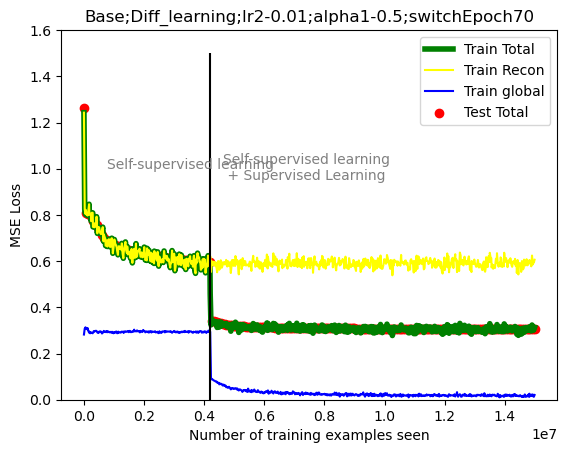

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='green', linewidth = 4)
plt.plot(train_counter, train_recon_losses, color='yellow')
plt.plot(train_counter, train_global_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Total', 'Train Recon', 'Train global', 'Test Total'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylim([0, 1.6])
#plt.ylim([0, 2.1])
plt.ylabel('MSE Loss')

#plt.vlines(70*len(train_data_loader.dataset),0, 1.6, color='black')
plt.vlines(70*len(train_data_loader.dataset),0, 1.5, color='black')
plt.text(13*len(train_data_loader.dataset), 1, 'Self-supervised learning', fontsize=10, color='grey')
plt.text(77*len(train_data_loader.dataset), 0.95, 'Self-supervised learning\n + Supervised Learning', fontsize=10, color='grey')

plt.title(f"Base;Diff_learning;lr2-0.01;alpha1-0.5;switchEpoch70")
#plt.savefig(f'./Plots/Losses/Base;Diff_learning;lr2-0.05;alpha1-0.5;switchEpoch70.png', dpi=300, bbox_inches='tight')
plt.show()

In [60]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='green', linestyle= 'dashed', linewidth = 4)
plt.plot(train_counter, train_recon_losses, color='yellow')
plt.plot(train_counter, train_global_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.vlines(0.42*10**7,0, 100, color='black')
plt.vlines(0.84*10**7,0, 100, color='black', linestyle='dashed')
plt.legend(['Train Total', 'Train Recon', 'Train global', 'Test Total'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylim([0, 1.4])
plt.ylabel('MSE Loss')
plt.title(f"Normal;Alpha={AlphaForEpochSup140};")
plt.savefig(f'./Plots/Losses/Normal;Diff_learning;Alpha={AlphaForEpochSup140}.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/8c/nyqgv1692611ml62r5vpckym0000gn/T/ipykernel_54161/1073852752.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [21]:
print(len(test_ssim))

252


In [73]:

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_ssim, color='green')
plt.scatter(test_counter, test_ssim, color='red')
plt.legend(['Train','Test'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.vlines(0.42*10**7, -0.1, 0.2, color='black')
plt.vlines(0.84*10**7, -0.1, 0.2, color='black', linestyle='dashed')
plt.ylim([-0.1, 0.2])
last_test_ssim = round(test_ssim[-1], 3)
plt.hlines(last_test_ssim, xmin=0, xmax=max(train_counter), colors='grey', linestyles='dashed')
plt.text(-2200000, last_test_ssim, f'{last_test_ssim}', fontsize=10, verticalalignment='center', color='grey')
plt.ylabel('SSIM score')
plt.title(f"Normal;Alpha={AlphaForEpochSup140}")
plt.savefig(f'./Plots/SSIM/Normal;Diff_learning;Alpha={AlphaForEpochSup140}_1.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/8c/nyqgv1692611ml62r5vpckym0000gn/T/ipykernel_54161/1647135458.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


TypeError: float() argument must be a string or a real number, not 'dict'

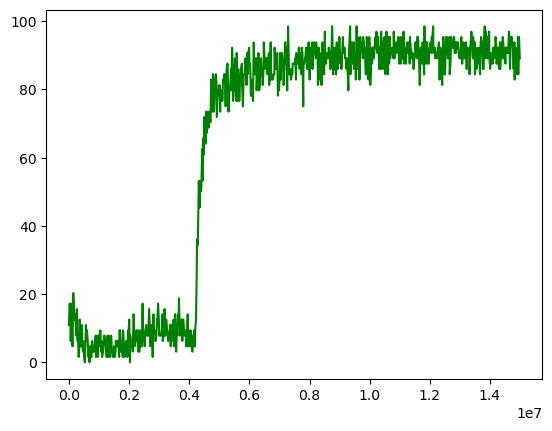

In [24]:

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_acc, color='green')
plt.scatter(test_counter, test_acc, color='red')
plt.legend(['Train','Test'], loc='upper left')
plt.xlabel('Number of training examples seen')
plt.ylim([0, 100])
plt.xlim([-100000, num_epochs*len(train_data_loader.dataset)])
plt.ylabel('Accuracy (classifier)')
plt.vlines(70*len(train_data_loader.dataset),0, 100, color='black')

plt.text(15*len(train_data_loader.dataset), 66, 'Self-supervised learning', fontsize=10, color='grey')
plt.text(83*len(train_data_loader.dataset), 62, 'Self-supervised learning\n + Supervised Learning', fontsize=10, color='grey')
#plt.text(15*len(train_data_loader.dataset), 35, 'Self-supervised learning', fontsize=10, color='grey')
#plt.text(77*len(train_data_loader.dataset), 31, 'Self-supervised learning\n + Supervised Learning', fontsize=10, color='grey')
last_test_acc = round(test_acc[-1], 1)
plt.hlines(last_test_acc, xmin=0, xmax=max(train_counter), colors='grey', linestyles='dashed')
plt.text(-850000, last_test_acc, f'{last_test_acc}%', fontsize=10, verticalalignment='center', color='grey')
#plt.text(-900000, last_test_acc, f'{last_test_acc}%', fontsize=10, verticalalignment='center', color='grey')

plt.title(f"Base;Diff_learning;lr2-0.01;alpha1-0.5;switchEpoch70")
#plt.savefig(f'./Plots/Accuracies/Base;Diff_learning;lr2-0.01;alpha1-0.5;switchEpoch70.png', dpi=300, bbox_inches='tight')
plt.show()

In [72]:
import matplotlib.pyplot as plt

colors = ['black', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
labels = [f'{i}' for i in range(10)]

fig = plt.figure()
for i in range(10):
    plt.plot(range(num_epochs+1), [epoch_acc[i] for epoch_acc in test_acc], color=colors[i])
mean = [np.mean(list(i.values())) for i in test_acc]
plt.scatter(range(num_epochs+1), mean, color='red')

legend_labels = []
for i, label in enumerate(labels):
    legend_labels.append(label)
legend_labels.append('Mean')

legend_handles = [plt.Line2D([0], [0], color=color, lw=2) for color in colors]
legend_handles.append(plt.Line2D([0], [0], marker='o', color='red', lw=0, markerfacecolor='red'))

#plt.legend(legend_handles, legend_labels, loc='upper right')
plt.legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.vlines(70,0, 100, color='black')
plt.vlines(140,0, 100, color='black', linestyle='dashed')

last_test_acc = round(mean[-1], 1)
plt.hlines(last_test_acc, xmin=0, xmax=max(train_counter), colors='grey', linestyles='dashed')
plt.text(-25, last_test_acc +2, f'{last_test_acc}%', fontsize=10, verticalalignment='center', color='grey')

plt.xlabel('Number of epochs')
plt.xlim([0, num_epochs])
plt.ylim([0, 100])
plt.ylabel('Accuracy % (classifier)')
plt.title(f"Normal;TestAcc;Alpha={AlphaForEpochSup140}")
plt.savefig(f'./Plots/Accuracies/Normal;TestAcc;Diff_learning;Alpha={AlphaForEpochSup140}_1.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/8c/nyqgv1692611ml62r5vpckym0000gn/T/ipykernel_54161/3120480987.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


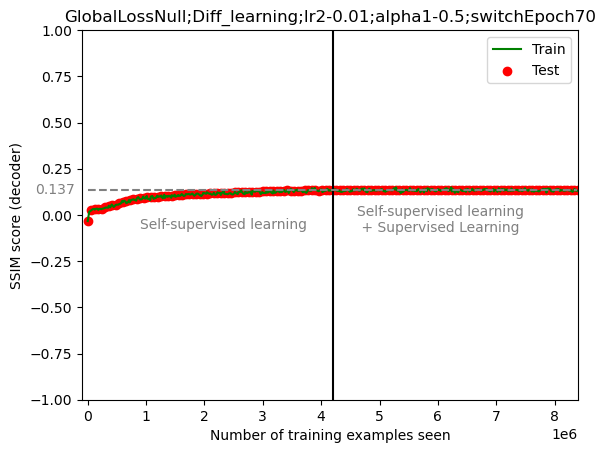

In [14]:

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_ssim, color='green')
plt.scatter(test_counter, test_ssim, color='red')
plt.legend(['Train','Test'], loc='upper right')
plt.xlabel('Number of training examples seen')
#plt.ylim([-0.1, 0.2])
plt.ylim([-1, 1])
plt.xlim([-100000, num_epochs*len(train_data_loader.dataset)])
plt.ylabel('SSIM score (decoder)')
#plt.vlines(70*len(train_data_loader.dataset),-0.1, 0.2, color='black')
plt.vlines(70*len(train_data_loader.dataset),-1, 1, color='black')
#plt.text(15*len(train_data_loader.dataset), -0.25, 'Self-supervised learning', fontsize=10, color='grey')
#plt.text(77*len(train_data_loader.dataset), -0.34, 'Self-supervised learning\n + Supervised Learning', fontsize=10, color='grey')
plt.text(15*len(train_data_loader.dataset), -0.075, 'Self-supervised learning', fontsize=10, color='grey')
plt.text(77*len(train_data_loader.dataset), -0.090, 'Self-supervised learning\n + Supervised Learning', fontsize=10, color='grey')

last_test_ssim = round(test_ssim[-1], 3)
plt.hlines(last_test_ssim, xmin=0, xmax=max(train_counter), colors='grey', linestyles='dashed')
plt.text(-900000, last_test_ssim, f'{last_test_ssim}', fontsize=10, verticalalignment='center', color='grey')

plt.title(f"Base;Diff_learning;lr2-0.01;alpha1-0.5;switchEpoch70") 
#plt.savefig(f'./Plots/SSIM/Base;Diff_learning;lr2-0.01;alpha1-0.5;switchEpoch70_2.png', dpi=300, bbox_inches='tight')
plt.show()


In [50]:

import csv
import os


headers = [
    "DateTime", "NumEpochs", "SwitchEpoch", "AlphaForEpochSup140", "Condition", "Digits", "SilhouetteScore", "NMI",
    "acc_0", "acc_1", "acc_2", "acc_3", "acc_4", "acc_5", "acc_6", "acc_7", "acc_8", "acc_9",
    "acc_mean", "SSIM_mean", "x_class_as_y", "y_class_as_x"
]


file_name = 'data.csv'

with open(file_name, 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    print(f"Created {file_name} with headers.")




Created data.csv with headers.
